# Imports

In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/guitarsounds')
%load_ext autoreload

In [3]:
%autoreload 2
from guitarsounds import Sound, Signal
import guitarsounds as guit

In [4]:
import librosa
import librosa.display
from soundfile import write
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
import scipy
from scipy import signal as sig
from noisereduce import reduce_noise

# Computing the difference between FFTS

In [6]:
# Get the soundfile paths
paths = []
samples = list(range(1, 9))
tries = list(range(1, 10))
for sample in samples:
    unit = []
    for trie in tries:
        unit.append('soundfiles/test_leste/' + str(sample) + '-' + str(trie) + '.wav')
    paths.append(unit)

In [8]:
S1 = Sound(paths[0][0])
S2 = Sound(paths[1][0])
S3 = Sound(paths[5][0])
S1.condition(verbose=False)
S2.condition(verbose=False)
S3.condition(verbose=False)

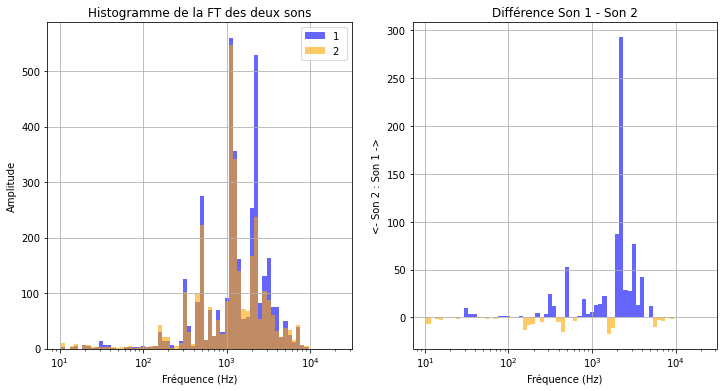

In [9]:
guit.fft_diff(S1, S2, fraction=6)

# Coherence between two signals

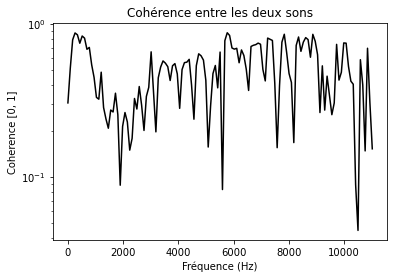

In [12]:
guit.coherence(S1, S2)

# Continuous Wavelet transform

### Importing the sounds :

In [14]:
Sound1 = Sound('soundfiles/flax_carbon/Carbon_D0_2.wav')
Sound2 = Sound('soundfiles/flax_carbon/Wood_D0_2.wav')
Sound1.condition()
Sound2.condition()

### Base wavelet scalogram for the two signals :

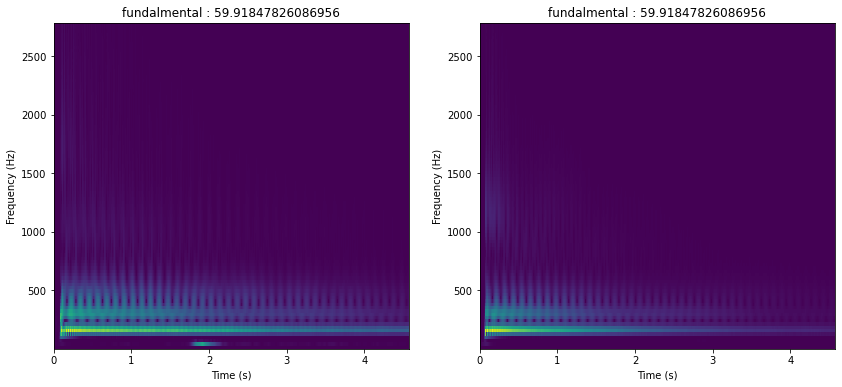

In [25]:
Sound1, Sound2 = guit.equalize_time(Sound1, Sound2)

fs = Sound1.signal.sr
time1 = Sound1.signal.time()
time2 = Sound2.signal.time()

# Extract nominal values from signal
freqs = np.linspace(1, fs/8, 99)
delta = freqs[1] - freqs[0]

# Wavelet function parameter
w = 5

# Wavelet parameters
widths2 = w*fs / (2*freqs*np.pi)

# Computing the wavelet scalogram
CWT1 = sig.cwt(Sound1.signal.signal, sig.morlet2, widths2)
CWT2 = sig.cwt(Sound2.signal.signal, sig.morlet2, widths2)

# Slicing the time vector
index1 = int(CWT1.shape[1]//2)
indey1 = int(CWT1.shape[0]//1)
index2 = int(CWT2.shape[1]//2)
indey2 = int(CWT1.shape[0]//1)

# Adding 1 sample to freqs
freqs = np.append(freqs, freqs[-1] + delta)

# plot
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
Z =  np.abs(CWT1)[:indey1, :index1]
plt.pcolormesh(time1[:index1+1], freqs[:indey1+1], Z)
plt.title('fundalmental : ' + str(Sound1.fundamental))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.subplot(1,2,2)
plt.pcolormesh(time2[:index2+1], freqs[:indey2+1], np.abs(CWT2)[:indey2, :index2], shading="flat")
plt.title('fundalmental : ' + str(Sound2.fundamental))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

The wavelet transforms allows to keep all the precision in the time, but makes it hard to have a good definition in the frequency domain.

### STFT Spectrogram for reference :

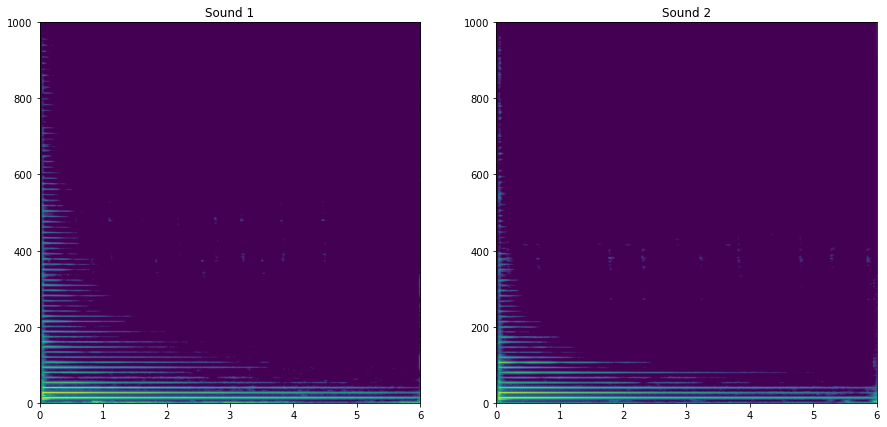

In [23]:
Sound1.signal.spectrogram()
Sound1.signal.spectrogram()

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.imshow(Sound1.signal.spectrogram()[:(fs//4), :], origin='lower', extent=[0, 6, 0, 1000], aspect='auto')
plt.title('Sound 1')

plt.subplot(1,2,2)
plt.imshow(Sound2.signal.spectrogram()[:(fs//4), :], origin='lower', extent=[0, 6, 0, 1000], aspect='auto')
plt.title('Sound 2')
plt.show()

### Frequency bin analysis using wavelet transforms

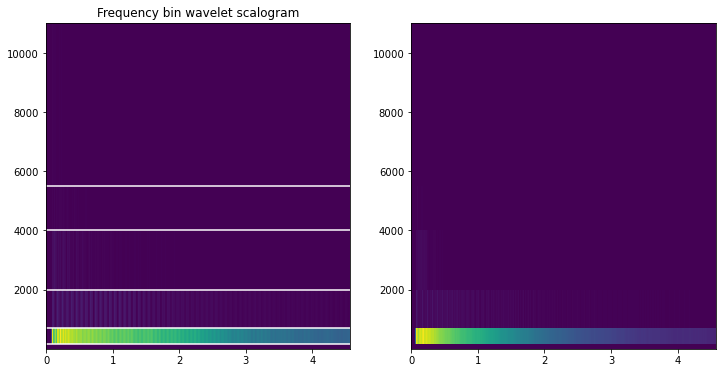

In [26]:
freq = np.array([1, 150,  700, 2000, 4000, 5500])

widths = 5*fs/(2*freq*np.pi) # Wavelet widths

# Computing the wavelet scalogram
CWT1 = sig.cwt(Sound1.signal.signal, sig.morlet2, widths)
CWT2 = sig.cwt(Sound2.signal.signal, sig.morlet2, widths)

# Slices for the time vector
index1 = int(CWT1.shape[1]//2)
index2 = int(CWT2.shape[1]//2)

# Adding the upper freq value
freqs = np.append(freq, fs/2)

# Building the lines to separate the bins :
x_s = []
y_s = []
max_x = (len(Sound1.signal.signal)//2)/fs
for f in freq[1:]:
    x_i = []
    y_i = []
    x_i.append(0)
    x_i.append(max_x)
    y_i.append(f)
    y_i.append(f)
    x_s.append(x_i)
    y_s.append(y_i)


# plot
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.pcolormesh(time1[:index1+1], freqs, np.abs(CWT1)[:, :index1])
for xi, yi in zip(x_s, y_s):
    plt.plot(xi, yi, color='w')
plt.title('Frequency bin wavelet scalogram')
plt.subplot(1,2,2)
plt.pcolormesh(time2[:index2+1], freqs, np.abs(CWT2)[:, :index2])
plt.show()

### Making the bin plot using wavelet transform

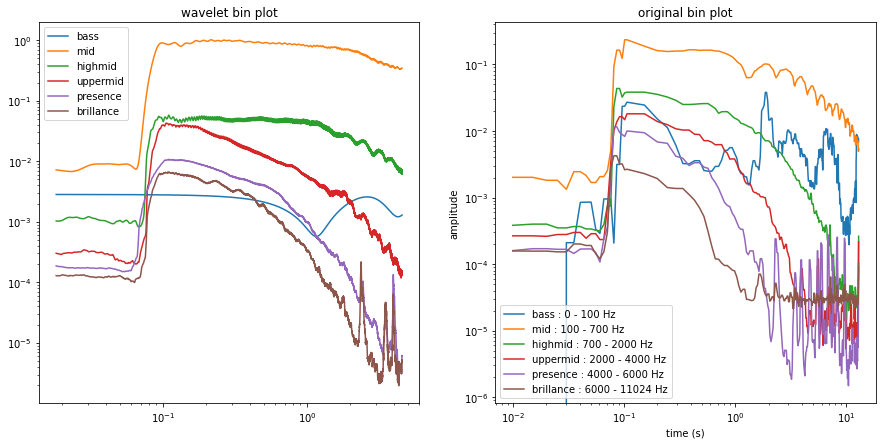

In [29]:
# Get the data
bass, mid, highmid, uppermid, presence, brillance = np.abs(CWT1)

# filter the data
if True:
    bass = bass
    mid = sig.savgol_filter(mid, 401, 1)
    highmid = sig.savgol_filter(highmid, 401, 1)
    uppermid = sig.savgol_filter(uppermid, 401, 1)
    presence = sig.savgol_filter(presence, 801, 1)
    brillance = sig.savgol_filter(brillance, 401, 1)

# reassemble the data
Smooth_signals = [bass, mid, highmid, uppermid, presence, brillance]


# Plot the data
bins = ['bass', 'mid', 'highmid', 'uppermid', 'presence', 'brillance']
max_index = int(len(Sound1.signal.time())//2)
time = Sound1.signal.time()[:max_index]

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title('wavelet bin plot')
for transform, bine in zip(Smooth_signals, bins):
    plt.plot(time[400:], transform[400:max_index], label=bine)
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.subplot(1,2,2)
plt.title('original bin plot')
Sound1.plot_freq_bins()
    

### Wavelet transform test

In [30]:
f = 2000 #Hz
t = np.arange(0, 6, 1/fs)
s = np.sin(np.pi*2*f*t)*np.exp(-0.5*t)
Test_signal = Signal(s, fs, guit.SP)

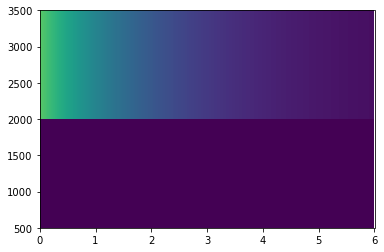

In [32]:
freq = np.array([1000, 3000])
plot_freq = [500, 2000, 3500]

widths = 5*fs/(2*freq*np.pi) # Wavelet widths

# Computing the wavelet scalogram
CWT3 = sig.cwt(Test_signal.signal, sig.morlet2, widths)

# Plot
plt.pcolormesh(np.append(t, t[-1]+(1/fs)), plot_freq, np.abs(CWT3))
plt.show()

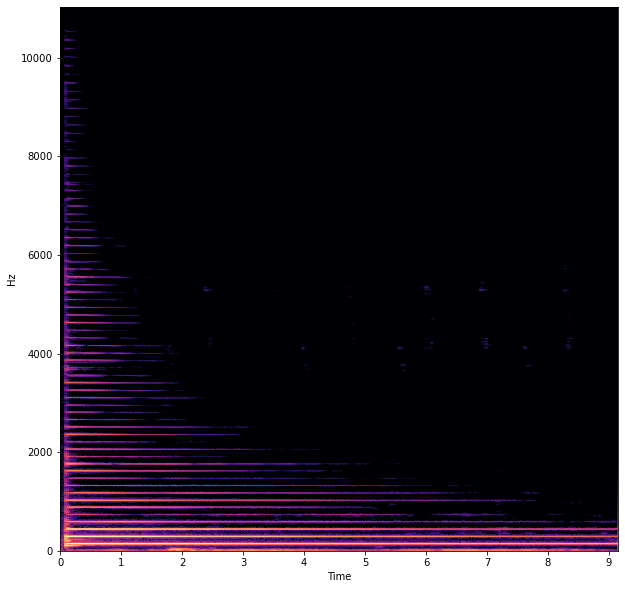

In [38]:
# Compute the spectrogram data
D = librosa.stft(Sound1.signal.signal)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10,10))
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
plt.show()